In [0]:
!pip3 -qq install torch==0.4.1
!pip -qq install torchtext==0.3.1
!pip -qq install torchvision==0.2.1
!pip -qq install spacy==2.0.16
!python -m spacy download en
!pip install sacremoses==0.0.5
!pip install subword_nmt==0.3.5
!wget -qq http://www.manythings.org/anki/rus-eng.zip 
!unzip rus-eng.zip

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

# Machine Translation

Мы уже несколько раз смотрели на эту картинку:

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg =x250)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

В POS tagging мы (ну, некоторые точно) использовали важную идею: сначала некоторой функцией над символами строился эмбеддинг для слова (например, many to one rnn'кой на картинке). Потом другая rnn'ка строила эмбеддинги слов с учетом их контекста. А дальше это всё классифицируется логистической регрессией.

Тут важно то, что мы обучаем encoder для построения эмбеддингов end2end - прямо в составе сети (это основное отличие нейросетей от классических подходов - в умении делать end2end).

Другое, что мы делали - это языковые модели. Вот, типа такого:
![](https://hsto.org/web/dc1/7c2/c4e/dc17c2c4e9ac434eb5346ada2c412c9a.png =x200)

Обратите внимание на красную стрелку - она показывает передачу скрытого состояния, которое отвечает за память сети.

А теперь совместим эти две идеи:

![](https://raw.githubusercontent.com/tensorflow/nmt/master/nmt/g3doc/img/seq2seq.jpg =x400)  
*From [tensorflow/nmt](https://github.com/tensorflow/nmt)*

Выглядит все почти как языковая модель, но в синей части предсказания не делаются, используется только последнее скрытое состояние.

Синяя часть сети называется энкодер, она строит эмбеддинг последовательности. Красная часть - декодер, работает как обычная языковая модель, но учитывает результат работы энкодера.

В итоге, энкодер учится эффективно извлекать смысл из последовательности слов, а декодер должен строить по ним новую последовательность. Это может быть последовательностью слов перевода, или последовательностью слов в ответе чат бота, или еще чем-то в зависимости от вашей испорченности.

## Подготовка данных

Начнем с чтения данных. Возьмем их у anki, поэтому они немного специфичны:

In [3]:
!shuf -n 10 rus.txt

Do you think I need to do that?	Думаете, мне нужно это сделать?
Do you have a car?	У вас есть автомобиль?
I shut the door behind me.	Я закрыл за собой дверь.
If I knew anything, I'd tell you.	Если бы я знал что-то, я бы сказал тебе.
Are they Japanese?	Они японки?
This cap belongs to Tom.	Эта шапка принадлежит Тому.
Please don't do anything stupid.	Пожалуйста, не делайте глупостей.
I think you're putting in too much sugar.	По-моему, вы кладёте слишком много сахара.
I don't think that you'll be allowed to do that.	Вряд ли тебе разрешат это сделать.
Don't look at Tom.	Не смотрите на Тома.


Токенизируем их:

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
fields = [('source', source_field), ('target', target_field)]

In [5]:
source_field.preprocess("It's surprising that you haven't heard anything about her wedding.")

['It',
 "'s",
 'surprising',
 'that',
 'you',
 'have',
 "n't",
 'heard',
 'anything',
 'about',
 'her',
 'wedding',
 '.']

In [6]:
target_field.preprocess('Удивительно, что ты ничего не слышал о её свадьбе.')

['Удивительно',
 ',',
 'что',
 'ты',
 'ничего',
 'не',
 'слышал',
 'о',
 'её',
 'свадьбе',
 '.']

In [7]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = source_field.preprocess(source_text)
        target_text = target_field.preprocess(target_text)
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [00:49<00:00, 6613.09it/s]


Построим датасеты:

In [8]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=3)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 256), shuffle=True, device=DEVICE, sort=False
)

Train size = 83261
Test size = 14693
Source vocab size = 5267
Target vocab size = 10482


In [9]:
source_field.process([source_field.preprocess("It's surprising that you haven't heard anything about her wedding.")])

tensor([[  43],
        [  15],
        [5161],
        [  14],
        [   6],
        [  22],
        [   9],
        [ 254],
        [ 132],
        [  54],
        [  96],
        [ 984],
        [   3],
        [   2]])

In [10]:
source_field.vocab.itos

['<unk>',
 '<pad>',
 '</s>',
 '.',
 'I',
 'Tom',
 'you',
 'to',
 '?',
 "n't",
 'the',
 'a',
 'is',
 'do',
 'that',
 "'s",
 'me',
 'was',
 'in',
 'You',
 'did',
 'it',
 'have',
 'of',
 'Mary',
 'know',
 ',',
 'for',
 'Do',
 "'m",
 'We',
 'want',
 'this',
 'be',
 'your',
 'with',
 'are',
 'He',
 'not',
 'my',
 'he',
 'The',
 "'re",
 'It',
 'on',
 'like',
 'what',
 'think',
 "'ll",
 'and',
 'his',
 'What',
 'go',
 "'ve",
 'about',
 'at',
 'here',
 'has',
 'told',
 'will',
 'can',
 'going',
 'very',
 'How',
 'were',
 'She',
 'does',
 'help',
 'him',
 'we',
 'time',
 'one',
 'need',
 'would',
 'tell',
 'had',
 'This',
 'Why',
 'all',
 'ca',
 'They',
 'us',
 'Boston',
 'said',
 'That',
 "'d",
 'Did',
 'Are',
 'up',
 'never',
 'as',
 'there',
 'get',
 'should',
 'see',
 'been',
 'her',
 'could',
 'out',
 'so',
 'got',
 'from',
 'an',
 'just',
 'come',
 'My',
 'Is',
 'much',
 'by',
 'now',
 'French',
 'no',
 'who',
 'good',
 'home',
 'thought',
 'Let',
 'Can',
 'how',
 'too',
 'back',
 'There'

In [11]:
target_field.vocab.itos

['<unk>',
 '<pad>',
 '<s>',
 '</s>',
 '.',
 ',',
 'Том',
 'Я',
 'не',
 '?',
 'что',
 'в',
 'это',
 'на',
 'Ты',
 'с',
 'мне',
 'Мэри',
 'я',
 'ты',
 'Тома',
 'Вы',
 'меня',
 'Это',
 'У',
 'Мы',
 'Он',
 'и',
 'Тому',
 'вы',
 'бы',
 'сказал',
 'был',
 'чтобы',
 'Не',
 'тебя',
 'Мне',
 'очень',
 'у',
 'тебе',
 'как',
 'так',
 'было',
 'его',
 'знаю',
 'хочу',
 'за',
 'он',
 'есть',
 'Она',
 'сделать',
 'вас',
 'всё',
 'ещё',
 'Что',
 'о',
 'здесь',
 'вам',
 'Они',
 'Томом',
 'хотел',
 'знал',
 'Почему',
 'этого',
 'могу',
 'Как',
 'из',
 'никогда',
 'нужно',
 'будет',
 'мы',
 'этом',
 'больше',
 '-',
 'нас',
 'делать',
 'сделал',
 'надо',
 '!',
 'уже',
 'по',
 'нет',
 'В',
 'быть',
 'к',
 'была',
 'нам',
 'хочет',
 'её',
 'от',
 'об',
 'может',
 'думаю',
 'для',
 'нравится',
 'много',
 'когда',
 'то',
 'должен',
 'думал',
 'помочь',
 'сегодня',
 'ничего',
 'Тебе',
 'знает',
 'ему',
 'видел',
 'сейчас',
 'день',
 'ли',
 'сказать',
 'со',
 'были',
 'только',
 'себя',
 'Вам',
 'всегда',
 'Бо

## Seq2seq модель

Пора писать простой seq2seq. Разобьем модель на несколько модулей - Encoder, Decoder и их объединение. 

Encoder должен быть подобен символьной сеточке в POS tagging'е: эмбеддить токены и запускать rnn'ку (в данном случае будем пользоваться GRU) и отдавать последнее скрытое состояние.

Decoder почти такой же, только еще и предсказывает токены на каждом своем шаге.

**Задание** Реализовать модели.

In [0]:
batch = next(iter(train_iter))

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1, bidirectional=False):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, 
                           num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, inputs, hidden=None):
        embs = self._emb(inputs)
        _, hidden = self._rnn(embs, hidden)
        return hidden

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1):
        super().__init__()
        
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(encoder_output)

        embs = self._emb(inputs)
        output, hidden = self._rnn(embs, hidden)
        output = self._out(output)
        return output, hidden

    def init_hidden(self, encoder_output):
        encoder_output = torch.cat((encoder_output[0], encoder_output[1]), -1).unsqueeze(0)
        return self._h0(encoder_output)

Модель перевода будет просто сперва вызывать Encoder, а потом передавать его скрытое состояние декодеру в качестве начального.

In [0]:
class TranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=128, 
                 rnn_hidden_dim=256, num_layers=1, bidirectional_encoder=False):
        
        super().__init__()
        self._bidirectional = bidirectional_encoder
        
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = Decoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers)
        
    def forward(self, source_inputs, target_inputs):
        encoder_hidden = self.encoder(source_inputs)
        
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
        
        return self.decoder(target_inputs, encoder_hidden, hidden)

In [16]:
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

model(batch.source, batch.target)

(tensor([[[ 0.2808, -0.2136,  0.0629,  ..., -0.0855, -0.0740, -0.0161],
          [ 0.2866, -0.1960,  0.0674,  ..., -0.0928, -0.0508,  0.0209],
          [ 0.2782, -0.2112,  0.0615,  ..., -0.0772, -0.0809, -0.0357],
          ...,
          [ 0.2910, -0.2100,  0.0643,  ..., -0.0865, -0.0726, -0.0042],
          [ 0.2834, -0.2114,  0.0616,  ..., -0.0791, -0.0848, -0.0380],
          [ 0.2800, -0.1535,  0.0718,  ..., -0.1334,  0.0033,  0.0370]],
 
         [[ 0.1844, -0.0366,  0.1625,  ..., -0.0488,  0.0924, -0.0210],
          [ 0.1066, -0.2937,  0.2088,  ..., -0.1372, -0.1307, -0.2108],
          [ 0.1842, -0.0349,  0.1618,  ..., -0.0451,  0.0884, -0.0312],
          ...,
          [ 0.0845, -0.0434,  0.0731,  ..., -0.1144, -0.1152, -0.0267],
          [ 0.2501,  0.1042,  0.0014,  ..., -0.0930, -0.1618,  0.2731],
          [ 0.0898, -0.0553,  0.1468,  ..., -0.1892, -0.0354, -0.2349]],
 
         [[ 0.0785,  0.2803,  0.0609,  ..., -0.0671,  0.0408,  0.0555],
          [ 0.0477, -0.2087,

Реализуем простой перевод - жадный. На каждом шаге будем выдавать самый вероятный из предсказываемых токенов:

![](https://github.com/tensorflow/nmt/raw/master/nmt/g3doc/img/greedy_dec.jpg =x400)  
*From [tensorflow/nmt](https://github.com/tensorflow/nmt)*

**Задание** Реализовать функцию.

In [0]:
def greedy_decode(model, source_text, source_field, target_field):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        result = [] # list of predicted tokens indices
        inputs = source_field.process([source_field.preprocess(source_text)]).to(DEVICE)
        encoder_hidden = model.encoder(inputs)
        hidden = encoder_hidden
        if model._bidirectional:
            hidden = None
        step = LongTensor([[bos_index]])
        
        for _ in range(30):
            step, hidden = model.decoder(step, encoder_hidden, hidden)
            step = step.argmax(-1)
            
            if step.item() == eos_index:
                break
            
            result.append(step)
            
        return ' '.join(target_field.vocab.itos[ind.squeeze().item()] for ind in result)

In [18]:
greedy_decode(model, "Do you believe?", source_field, target_field)

'нажал русло получите лабораторию времена память одежда происходят Доброе Кому погас мячик пойду моём поменяться моих Америки знания уроки обуви развелись играй жены воскресенья умолять победим серёжку заставлять зуб выбрасывайте'

Нужно как-то оценивать модель.

Обычно для этого используется [BLEU скор](https://en.wikipedia.org/wiki/BLEU) - что-то вроде точности угадывания n-gram из правильного (референсного) перевода.

**Задание** Реализовать функцию оценки: для батчей из `iterator` предсказать их переводы, обрезать по `</s>` и сложить правильные варианты и предсказанные в `refs` и `hyps` соответственно.

In [0]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, iterator):
    model.eval()
    refs, hyps = [], []
    
    bos_index = iterator.dataset.fields['target'].vocab.stoi[BOS_TOKEN]
    eos_index = iterator.dataset.fields['target'].vocab.stoi[EOS_TOKEN]
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            encoder_hidden = model.encoder(batch.source)
            hidden = encoder_hidden
            if model._bidirectional:
                hidden = None
            result = [LongTensor([bos_index]).expand(1, batch.target.shape[1])]
            
            for _ in range(30):
                step, hidden = model.decoder(result[-1], encoder_hidden, hidden)
                step = step.argmax(-1)
                result.append(step)
            
            targets = batch.target.data.cpu().numpy().T
            _, eos_indices = np.where(targets == target_field.vocab.stoi['</s>'])

            targets = [target[:eos_ind] for eos_ind, target in zip(eos_indices, targets)]
            refs.extend(targets)
            
            result = torch.cat(result)
            result = result.data.cpu().numpy().T
            _, eos_indices = np.where(result == target_field.vocab.stoi['</s>'])

            result = [res[:eos_ind] for eos_ind, res in zip(eos_indices, result)]
            hyps.extend(result)
            
    return corpus_bleu([[ref] for ref in refs], hyps) * 100

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):                
                logits, _ = model(batch.source, batch.target)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            print('\nVal BLEU = {:.2f}'.format(evaluate_model(model, val_iter)))

In [21]:
# After some research I've found that 8 is an optimal epochs_count
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=8, val_iter=test_iter)

[2 / 8] Train: Loss = 1.90150, PPX = 6.70:   0%|          | 1/2602 [00:00<07:06,  6.10it/s]


Val BLEU = 7.45


[3 / 8] Train: Loss = 1.55970, PPX = 4.76:   0%|          | 1/2602 [00:00<07:09,  6.06it/s]


Val BLEU = 8.76


[4 / 8] Train: Loss = 1.24199, PPX = 3.46:   0%|          | 2/2602 [00:00<06:57,  6.23it/s]


Val BLEU = 10.06


[5 / 8] Train: Loss = 1.17445, PPX = 3.24:   0%|          | 1/2602 [00:00<07:45,  5.59it/s]


Val BLEU = 10.25


[6 / 8] Train: Loss = 0.82616, PPX = 2.28:   0%|          | 1/2602 [00:00<07:24,  5.86it/s]


Val BLEU = 10.62


[7 / 8] Train: Loss = 0.66860, PPX = 1.95:   0%|          | 1/2602 [00:00<07:30,  5.78it/s]


Val BLEU = 10.86


[8 / 8] Train: Loss = 0.73057, PPX = 2.08:   0%|          | 1/2602 [00:00<07:11,  6.03it/s]


Val BLEU = 11.34


[8 / 8]   Val: Loss = 1.76797, PPX = 5.86: 100%|██████████| 58/58 [00:01<00:00, 30.94it/s]



Val BLEU = 11.16


In [22]:
greedy_decode(model, "Do you believe?", source_field, target_field)

'Вы верите ?'

## Scheduled Sampling

До сих пор мы тренировали перевод, используя так называемый *teacher forcing*: в качестве выхода на предыдущем шаге декодер принимал всегда правильный токен. Проблема такого подхода - во время инференса правильный токен, скорее всего, не выберется хотя бы на каком-то шаге. Получится, что сеть училась на хороших входах, использоваться будет на плохом - это легко может всё поломать.

Альтернативный подход - прямо во время обучения сэмплировать токен с текущего шага и передавать его на следующий.

Такой подход не слишком-то обоснован математически (градиенты не прокидываются через сэмплирование), но его интересно реализовать и он зачастую улучшает качество.

**Задание** Обновите `Decoder`: замените вызов rnn'ки над последовательностью на цикл. На каждом шаге вероятностью `p` передавайте в качестве предыдущего выхода декодеру правильный вход, а иначе - argmax от предыдущего выхода (цикл должен быть похожим на те, которые есть в `greedy_decode` и `evaluate_model`). При передаче argmax вызывайте `detach`, чтобы градиенты не прокидывались. Все выходы собирайте в список, в конце сделайте `torch.cat`. 

В результате при вероятности, равной `p=1`, должно получиться как раньше, только медленнее. При обучении можно передавать `p=0.5`, на инференсе - `p=1`.

In [0]:
class SSDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, hidden=None, p=1):
        embs = self._emb(inputs)
        outputs = []
        cur_input = embs[:1]
        for i in range(embs.shape[0]):
            if i == 0 or np.random.rand() < p:
                cur_input = embs[i: i+1]
            else:
                cur_input = outputs[-1].argmax(-1).detach().unsqueeze(-1).expand(-1, -1, embs.shape[2]).float()
            output, hidden = self._rnn(cur_input, hidden)
            
            outputs.append(output)
        output = torch.cat(outputs)
        return self._out(output), hidden

In [0]:
class SSTranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=128, 
                 rnn_hidden_dim=256, num_layers=1, bidirectional_encoder=False):
        
        super().__init__()
        self._bidirectional = bidirectional_encoder
        
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = SSDecoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers)
        
    def forward(self, source_inputs, target_inputs, p=1):
        encoder_hidden = self.encoder(source_inputs)
        
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
        
        return self.decoder(target_inputs, encoder_hidden, encoder_hidden, p)

In [0]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def ss_do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = len(data_iter)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                # During training we allow our model to take tokens from previous iterations
                p = 0.5 if is_train else 1
                logits, _ = model(batch.source, batch.target, p)
                
                target = torch.cat((batch.target[1:], batch.target.new_ones((1, batch.target.shape[1]))))
                loss = criterion(logits.view(-1, logits.shape[-1]), target.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(), 
                                                                                         math.exp(loss.item())))
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def ss_fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None):
    best_val_loss = None
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = ss_do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        
        if not val_iter is None:
            val_loss = ss_do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            print('\nVal BLEU = {:.2f}'.format(evaluate_model(model, val_iter)))

In [26]:
# After some research I've found that 13 is an optimal epochs_count
ss_model = SSTranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(ss_model.parameters())

ss_fit(ss_model, criterion, optimizer, train_iter, epochs_count=13, val_iter=test_iter)

[2 / 13] Train: Loss = 3.41934, PPX = 30.55:   0%|          | 1/2602 [00:00<08:01,  5.40it/s]


Val BLEU = 6.04


[3 / 13] Train: Loss = 2.54643, PPX = 12.76:   0%|          | 1/2602 [00:00<08:02,  5.39it/s]


Val BLEU = 7.68


[4 / 13] Train: Loss = 1.92660, PPX = 6.87:   0%|          | 1/2602 [00:00<08:07,  5.34it/s]


Val BLEU = 8.49


[5 / 13] Train: Loss = 2.43712, PPX = 11.44:   0%|          | 1/2602 [00:00<07:55,  5.47it/s]


Val BLEU = 9.23


[6 / 13] Train: Loss = 2.23683, PPX = 9.36:   0%|          | 1/2602 [00:00<07:48,  5.55it/s]


Val BLEU = 9.59


  0%|          | 1/2602 [00:00<08:24,  5.16it/s]


Val BLEU = 10.03


[8 / 13] Train: Loss = 1.97480, PPX = 7.21:   0%|          | 1/2602 [00:00<08:12,  5.28it/s]


Val BLEU = 10.08


[9 / 13] Train: Loss = 1.41514, PPX = 4.12:   0%|          | 1/2602 [00:00<07:55,  5.46it/s]


Val BLEU = 10.37


  0%|          | 1/2602 [00:00<08:26,  5.13it/s]


Val BLEU = 10.40


[11 / 13] Train: Loss = 2.18041, PPX = 8.85:   0%|          | 1/2602 [00:00<08:05,  5.35it/s]


Val BLEU = 10.54


[12 / 13] Train: Loss = 1.26195, PPX = 3.53:   0%|          | 1/2602 [00:00<07:53,  5.49it/s]


Val BLEU = 10.61


[13 / 13] Train: Loss = 1.53380, PPX = 4.64:   0%|          | 1/2602 [00:00<07:48,  5.55it/s]


Val BLEU = 10.56


[13 / 13]   Val: Loss = 1.72237, PPX = 5.60: 100%|██████████| 58/58 [00:02<00:00, 24.61it/s]



Val BLEU = 10.64


In [27]:
greedy_decode(ss_model, "Do you believe?", source_field, target_field)

'Ты веришь ?'

## Beam Search

Другой способ бороться с ошибками в декодировании на инференсе - делать beam search. По сути это поиск в глубину с очень сильными отсечениями на каждом шаге:

![](https://image.ibb.co/dBRKkA/2018-11-06-13-53-40.png =x300)   
*From [cs224n, Machine Translation, Seq2Seq and Attention](http://web.stanford.edu/class/cs224n/lectures/lecture10.pdf)*

На картинке на каждом шаге выбирается два лучших (согласно предсказаниям сети) из четырех вариантов продолжений цепочек.

Для сравнения бимов используются суммы log-вероятностей токенов, входящих в бим. Чтобы получить log-вероятности, нужно просто вызвать `logsoftmax` у логитов. Преимущество сложения логарифмов перед умножением вероятностей должно быть понятно: нет таких проблем с численной неустойчивостью - умножая вероятности, близкие к нулю, мы очень шустро получим ноль в качестве скора бима.

В итоге нужно реализовать аналог `gready_decoding`. 

Beam будет состоять из последовательности индексов токенов (в начале - `[bos_index]`),  суммарного качества (в начале 0) и последнего `hidden` (в начале `encoder_hidden`).


In [0]:
def beam_search_decode(model, source_text, source_field, target_field, beam_size=5):
    bos_index = target_field.vocab.stoi[BOS_TOKEN]
    eos_index = target_field.vocab.stoi[EOS_TOKEN]
    
    model.eval()
    with torch.no_grad():
        inputs = source_field.process([source_field.preprocess(source_text)]).to(DEVICE)
        encoder_hidden = model.encoder(inputs)
        hidden = encoder_hidden
        if model._bidirectional:
            hidden = None
        beams = [([bos_index], 0, hidden)]
        
        for _ in range(30):
            _beams = []
            for beam in beams:
                step, hidden = model.decoder(LongTensor([[beam[0][-1]]]), encoder_hidden, beam[2])
                step = F.log_softmax(step, -1)
                positions = torch.topk(step, beam_size, dim=-1)[1]
                
                for i in range(beam_size):
                    seq = beam[0] + [positions[0, 0, i].item()]
                    score = beam[1] - step[0, 0, positions[0, 0, i]].item()
                    _beams.append((seq, score, hidden))
            beams = sorted(_beams, key = lambda x: x[1])[:beam_size]
        
        result = sorted(beams, key = lambda x: x[1])[0][0][1:]
        
        end_index = np.where(np.array(result) == eos_index)
            
        return ' '.join(target_field.vocab.itos[ind] for ind in result[:end_index[0][0]])

In [29]:
beam_search_decode(ss_model, "Where is your car?", source_field, target_field)

'Где ваша машина ?'

In [30]:
beam_search_decode(model, "Where is your car?", source_field, target_field)

'Где ваша машина ?'

## Улучшения модели

**Задание** Попробуйте повысить качество модели. Попробуйте: 
- Bidirectional encoder
- Dropout
- Stack moar layers

In [31]:
# After some research I've found that 7 is an optimal epochs_count
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab), bidirectional_encoder=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=7, val_iter=test_iter)

[2 / 7] Train: Loss = 2.19373, PPX = 8.97:   0%|          | 1/2602 [00:00<07:32,  5.75it/s]


Val BLEU = 8.42


[3 / 7] Train: Loss = 1.16896, PPX = 3.22:   0%|          | 1/2602 [00:00<07:14,  5.99it/s]


Val BLEU = 10.27


[4 / 7] Train: Loss = 0.73159, PPX = 2.08:   0%|          | 1/2602 [00:00<07:42,  5.62it/s]


Val BLEU = 10.75


[5 / 7] Train: Loss = 0.73980, PPX = 2.10:   0%|          | 1/2602 [00:00<07:38,  5.67it/s]


Val BLEU = 11.17


[6 / 7] Train: Loss = 0.67176, PPX = 1.96:   0%|          | 1/2602 [00:00<07:38,  5.68it/s]


Val BLEU = 11.22


[7 / 7] Train: Loss = 0.53717, PPX = 1.71:   0%|          | 1/2602 [00:00<07:34,  5.72it/s]


Val BLEU = 11.23


[7 / 7]   Val: Loss = 1.77494, PPX = 5.90: 100%|██████████| 58/58 [00:02<00:00, 27.99it/s]



Val BLEU = 11.31


In [32]:
beam_search_decode(model, "Where is your car?", source_field, target_field)

'Где твоя машина ?'

In [0]:
class DropDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1):
        super().__init__()
        
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)
        
        self._dropout = nn.Dropout()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, inputs, encoder_output, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(encoder_output)

        embs = self._emb(inputs)
        output, hidden = self._rnn(embs, hidden)
        output = self._out(self._dropout(output))
        return output, hidden

    def init_hidden(self, encoder_output):
        encoder_output = torch.cat((encoder_output[0], encoder_output[1]), -1).unsqueeze(0)
        return self._h0(encoder_output)

In [0]:
class DropTranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=128, 
                 rnn_hidden_dim=256, num_layers=1, bidirectional_encoder=False):
        
        super().__init__()
        self._bidirectional = bidirectional_encoder
        
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = DropDecoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers)
        
    def forward(self, source_inputs, target_inputs):
        encoder_hidden = self.encoder(source_inputs)
        
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
        
        return self.decoder(target_inputs, encoder_hidden, hidden)

In [36]:
# After some research I've found that 16 is an optimal epochs_count
model = DropTranslationModel(source_vocab_size=len(source_field.vocab),
                             target_vocab_size=len(target_field.vocab),
                             bidirectional_encoder=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=16, val_iter=test_iter)

[2 / 16] Train: Loss = 2.91187, PPX = 18.39:   0%|          | 1/2602 [00:00<07:19,  5.92it/s]


Val BLEU = 7.40


[3 / 16] Train: Loss = 2.50568, PPX = 12.25:   0%|          | 1/2602 [00:00<07:22,  5.88it/s]


Val BLEU = 9.16


[4 / 16] Train: Loss = 1.42126, PPX = 4.14:   0%|          | 1/2602 [00:00<07:33,  5.74it/s]


Val BLEU = 9.96


[5 / 16] Train: Loss = 1.90897, PPX = 6.75:   0%|          | 1/2602 [00:00<07:21,  5.89it/s]


Val BLEU = 10.68


[6 / 16] Train: Loss = 1.29481, PPX = 3.65:   0%|          | 1/2602 [00:00<07:26,  5.83it/s]


Val BLEU = 11.22


[7 / 16] Train: Loss = 1.37692, PPX = 3.96:   0%|          | 2/2602 [00:00<07:02,  6.15it/s]


Val BLEU = 11.50


[8 / 16] Train: Loss = 1.35194, PPX = 3.86:   0%|          | 1/2602 [00:00<07:19,  5.91it/s]


Val BLEU = 11.60


[9 / 16] Train: Loss = 1.06493, PPX = 2.90:   0%|          | 1/2602 [00:00<07:32,  5.75it/s]


Val BLEU = 12.02


[10 / 16] Train: Loss = 1.07610, PPX = 2.93:   0%|          | 1/2602 [00:00<07:36,  5.69it/s]


Val BLEU = 12.02


[11 / 16] Train: Loss = 1.10051, PPX = 3.01:   0%|          | 1/2602 [00:00<07:11,  6.02it/s]


Val BLEU = 12.18


[12 / 16] Train: Loss = 1.14833, PPX = 3.15:   0%|          | 1/2602 [00:00<07:12,  6.01it/s]


Val BLEU = 12.07


[13 / 16] Train: Loss = 0.92303, PPX = 2.52:   0%|          | 1/2602 [00:00<07:24,  5.85it/s]


Val BLEU = 12.28


[14 / 16] Train: Loss = 0.99228, PPX = 2.70:   0%|          | 1/2602 [00:00<07:19,  5.92it/s]


Val BLEU = 12.32


[15 / 16] Train: Loss = 0.80072, PPX = 2.23:   0%|          | 1/2602 [00:00<07:16,  5.96it/s]


Val BLEU = 12.41


[16 / 16] Train: Loss = 0.69968, PPX = 2.01:   0%|          | 1/2602 [00:00<07:11,  6.02it/s]


Val BLEU = 12.54


[16 / 16]   Val: Loss = 1.53015, PPX = 4.62: 100%|██████████| 58/58 [00:02<00:00, 27.34it/s]



Val BLEU = 12.27


In [37]:
beam_search_decode(model, "Where is your car?", source_field, target_field)

'Где твоя машина ?'

In [0]:
class BigDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1):
        super().__init__()
        
        self._h0 = nn.Linear(2 * rnn_hidden_dim, rnn_hidden_dim)

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._rnn = nn.GRU(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers, dropout=0.4)
        self._out_1 = nn.Linear(rnn_hidden_dim, 4 * rnn_hidden_dim)
        self._out_2 = nn.Linear(4 * rnn_hidden_dim, 2 * rnn_hidden_dim)
        self._dropout = nn.Dropout()
        self._out_3 = nn.Linear(2* rnn_hidden_dim, vocab_size)
        
    def forward(self, inputs, encoder_output, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(encoder_output)

        embs = self._emb(inputs)
        output, hidden = self._rnn(embs, hidden)
        output = self._out_3(self._dropout(self._out_2(self._dropout(self._out_1(output)))))
        return output, hidden

    def init_hidden(self, encoder_output):
        encoder_output = torch.cat((encoder_output[0], encoder_output[1]), -1).unsqueeze(0)
        return self._h0(encoder_output)

In [0]:
class BigTranslationModel(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, emb_dim=128, 
                 rnn_hidden_dim=256, num_layers=1, bidirectional_encoder=False):
        
        super().__init__()
        self._bidirectional = bidirectional_encoder
        
        self.encoder = Encoder(source_vocab_size, emb_dim, rnn_hidden_dim, num_layers, bidirectional_encoder)
        self.decoder = BigDecoder(target_vocab_size, emb_dim, rnn_hidden_dim, num_layers)
        
    def forward(self, source_inputs, target_inputs):
        encoder_hidden = self.encoder(source_inputs)
        
        hidden = encoder_hidden
        if self._bidirectional:
            hidden = None
        
        return self.decoder(target_inputs, encoder_hidden, hidden)

In [42]:
model = BigTranslationModel(source_vocab_size=len(source_field.vocab),
                            target_vocab_size=len(target_field.vocab),
                            bidirectional_encoder=True).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=20, val_iter=test_iter)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
[2 / 20] Train: Loss = 2.17345, PPX = 8.79:   0%|          | 1/2602 [00:00<07:57,  5.45it/s]


Val BLEU = 7.22


[3 / 20] Train: Loss = 1.95745, PPX = 7.08:   0%|          | 1/2602 [00:00<08:04,  5.37it/s]


Val BLEU = 8.76


[4 / 20] Train: Loss = 2.11117, PPX = 8.26:   0%|          | 1/2602 [00:00<08:13,  5.27it/s]


Val BLEU = 9.59


[5 / 20] Train: Loss = 1.75327, PPX = 5.77:   0%|          | 1/2602 [00:00<07:42,  5.62it/s]


Val BLEU = 10.60


[6 / 20] Train: Loss = 1.67057, PPX = 5.32:   0%|          | 1/2602 [00:00<07:43,  5.61it/s]


Val BLEU = 10.51


[7 / 20] Train: Loss = 1.48588, PPX = 4.42:   0%|          | 1/2602 [00:00<07:42,  5.62it/s]


Val BLEU = 11.61


[8 / 20] Train: Loss = 1.50566, PPX = 4.51:   0%|          | 1/2602 [00:00<07:48,  5.55it/s]


Val BLEU = 10.96


  0%|          | 1/2602 [00:00<08:25,  5.14it/s]


Val BLEU = 11.93


[10 / 20] Train: Loss = 1.43421, PPX = 4.20:   0%|          | 1/2602 [00:00<08:00,  5.41it/s]


Val BLEU = 12.29


[11 / 20] Train: Loss = 1.53915, PPX = 4.66:   0%|          | 1/2602 [00:00<07:43,  5.61it/s]


Val BLEU = 12.34


[12 / 20] Train: Loss = 1.29960, PPX = 3.67:   0%|          | 1/2602 [00:00<07:23,  5.86it/s]


Val BLEU = 12.44


[13 / 20] Train: Loss = 1.01324, PPX = 2.75:   0%|          | 1/2602 [00:00<07:30,  5.77it/s]


Val BLEU = 12.72


[14 / 20] Train: Loss = 1.01487, PPX = 2.76:   0%|          | 1/2602 [00:00<07:35,  5.72it/s]


Val BLEU = 12.60


[15 / 20] Train: Loss = 1.05260, PPX = 2.87:   0%|          | 1/2602 [00:00<08:19,  5.21it/s]


Val BLEU = 12.86


[16 / 20] Train: Loss = 1.00504, PPX = 2.73:   0%|          | 1/2602 [00:00<07:35,  5.71it/s]


Val BLEU = 13.03


[17 / 20] Train: Loss = 0.87252, PPX = 2.39:   0%|          | 1/2602 [00:00<07:36,  5.70it/s]


Val BLEU = 12.98


[18 / 20] Train: Loss = 0.78498, PPX = 2.19:   0%|          | 1/2602 [00:00<07:48,  5.55it/s]


Val BLEU = 12.77


[19 / 20] Train: Loss = 0.78096, PPX = 2.18:   0%|          | 1/2602 [00:00<07:41,  5.64it/s]


Val BLEU = 13.68


[20 / 20] Train: Loss = 0.90361, PPX = 2.47:   0%|          | 1/2602 [00:00<07:58,  5.44it/s]


Val BLEU = 13.79


[20 / 20]   Val: Loss = 1.63127, PPX = 5.11: 100%|██████████| 58/58 [00:02<00:00, 21.50it/s]



Val BLEU = 13.75


In [43]:
beam_search_decode(model, "Where is your car?", source_field, target_field)

'Где твоя машина ?'

## Byte-Pair Encoding

Мы можем представлять слова одним индексом - и использовать словные эмбеддинги как строки матрицы эмбеддингов.  
Можем считать их набором символов и получать словный эмбеддинг с помощью некоторой функции над символьными эмбеддингами.

Наконец, можем ещё использовать промежуточное представление - как набор подслов.

Несколько лет назад использование подслов предложили для задачи машинного перевода: [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/abs/1508.07909). Там использовалось byte-pair encoding.

По сути это процесс объединения самых частотных пар символов алфавита в новый суперсимвол. Пусть у нас есть словарь, состоящий из такого набора слов:  
`‘low·’, ‘lowest·’, ‘newer·’, ‘wider·’`   
(`·` означает конец слова)

Тогда первым может выучиться новый символ `r·`, за ним `l o` превратится в `lo`. К этому новому символу приклеится `w`: `lo w` $\to$ `low`. И так далее.

Утверждается, что таким образом выучатся, во-первых, все частотные и короткие слова, а во-вторых, все значимые подслова. Например, в полученном в результате алфавите должны найтись `ly·` и `tion·`.

Дальше слово можно разбить на набор подслов - и действовать, как с символами.

Здесь можно найти уже предобученные эмбеддинги: [BPEmb](https://github.com/bheinzerling/bpemb).

Обучим модель для них:

In [0]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

with open('data.en', 'w') as f_src, open('data.ru', 'w') as f_dst:
    for example in examples:
        f_src.write(' '.join(example.source) + '\n')
        f_dst.write(' '.join(example.target) + '\n')

bpe = {}
for lang in ['en', 'ru']:
    with open('./data.' + lang) as f_data, open('bpe_rules.' + lang, 'w') as f_rules:
        learn_bpe(f_data, f_rules, num_symbols=3000)
    with open('bpe_rules.' + lang) as f_rules:
        bpe[lang] = BPE(f_rules)

In [39]:
bpe['en'].process_line(' '.join(examples[10000].source))

'Can I make co@@ pi@@ es ?'

In [40]:
bpe['ru'].process_line(' '.join(examples[10000].target))

'Можно мне сделать ко@@ пи@@ и ?'

**Задание** Переобучиться с subword'ами вместо слов. Возможно, поменять их число (`num_symbols`)

In [0]:
from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

source_field = Field(tokenize='spacy', init_token=None, eos_token=EOS_TOKEN)
target_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
fields = [('source', source_field), ('target', target_field)]

In [42]:
from tqdm import tqdm

MAX_TOKENS_COUNT = 16
SUBSET_SIZE = .3

examples = []
with open('rus.txt') as f:
    for line in tqdm(f, total=328190):
        source_text, target_text = line.split('\t')
        source_text = bpe['en'].segment_tokens(source_field.preprocess(source_text))
        target_text = bpe['ru'].segment_tokens(target_field.preprocess(target_text))
        if len(source_text) <= MAX_TOKENS_COUNT and len(target_text) <= MAX_TOKENS_COUNT:
            if np.random.rand() < SUBSET_SIZE:
                examples.append(Example.fromlist([source_text, target_text], fields))

100%|██████████| 328190/328190 [01:16<00:00, 4309.02it/s]


In [43]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

source_field.build_vocab(train_dataset, min_freq=3)
print('Source vocab size =', len(source_field.vocab))

target_field.build_vocab(train_dataset, min_freq=3)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 256), shuffle=True, device=DEVICE, sort=False
)

Train size = 80850
Test size = 14268
Source vocab size = 2962
Target vocab size = 3089


In [46]:
# After some research I've found that 10 is an optimal epochs_count
model = TranslationModel(source_vocab_size=len(source_field.vocab), target_vocab_size=len(target_field.vocab)).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=10, val_iter=test_iter)

[2 / 10] Train: Loss = 2.68416, PPX = 14.65:   0%|          | 2/2527 [00:00<06:20,  6.64it/s]


Val BLEU = 5.69


[3 / 10] Train: Loss = 1.92872, PPX = 6.88:   0%|          | 2/2527 [00:00<06:17,  6.68it/s]


Val BLEU = 7.27


[4 / 10] Train: Loss = 1.63348, PPX = 5.12:   0%|          | 2/2527 [00:00<06:31,  6.45it/s]


Val BLEU = 8.30


[5 / 10] Train: Loss = 1.23990, PPX = 3.46:   0%|          | 2/2527 [00:00<06:32,  6.44it/s]


Val BLEU = 8.87


[6 / 10] Train: Loss = 1.32493, PPX = 3.76:   0%|          | 2/2527 [00:00<06:20,  6.63it/s]


Val BLEU = 9.48


[7 / 10] Train: Loss = 1.14285, PPX = 3.14:   0%|          | 2/2527 [00:00<06:30,  6.47it/s]


Val BLEU = 9.65


[8 / 10] Train: Loss = 1.20248, PPX = 3.33:   0%|          | 2/2527 [00:00<06:25,  6.55it/s]


Val BLEU = 9.79


[9 / 10] Train: Loss = 1.20433, PPX = 3.33:   0%|          | 2/2527 [00:00<06:29,  6.48it/s]


Val BLEU = 9.96


[10 / 10] Train: Loss = 0.75578, PPX = 2.13:   0%|          | 1/2527 [00:00<07:05,  5.93it/s]


Val BLEU = 10.16


[10 / 10]   Val: Loss = 2.10370, PPX = 8.20: 100%|██████████| 56/56 [00:01<00:00, 35.89it/s]



Val BLEU = 10.10


In [47]:
beam_search_decode(model, "Where is your car?", source_field, target_field)

'Где твоя машина ?'

# Image Captioning

Не обязательно энкодить последовательности слов. Наример, можно использовать сверточную сеть для энкодера картинки - и генерировать подпись к ней:

![](https://image.ibb.co/fpYdkL/image-captioning.png)  
*From [Image Captioning Tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)*

В результате получаются очень прикольные подписи: [https://cs.stanford.edu/people/karpathy/deepimagesent/](https://cs.stanford.edu/people/karpathy/deepimagesent/).

Скачаем данные для обучения:

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '13BP-6Xd6ymhGallRppYfJBO6UUjFCtbB'})
downloaded.GetContentFile('image_codes.npy')

downloaded = drive.CreateFile({'id': '1O7_3lyTyBMXsBBIt1PwUXwLdkyRQzZML'})
downloaded.GetContentFile('sources.txt')

downloaded = drive.CreateFile({'id': '1t-Dy8TzoRuTMoM7N9NJZKgWXfaw3b6KF'})
downloaded.GetContentFile('texts.txt')

!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!unzip Flickr8k_Dataset.zip

Скачем предобученную модельку:

In [0]:
from torchvision.models.inception import Inception3

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        x = x.clone()
        x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [0]:
from torch.utils.model_zoo import load_url

inception_model = BeheadedInception3()

inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
inception_model.load_state_dict(load_url(inception_url))

inception_model.eval()

Почему это вообще работает? Запустим модельку на картинке:

In [0]:
# Some stuff from the Internet to make things work
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


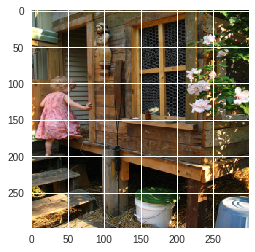

In [52]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline
    
img = plt.imread('Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)

In [53]:
import requests
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

with torch.no_grad():
    img_tensor = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0)
    _, _, logits = inception_model(img_tensor)
    _, top_classes = logits.topk(5)

    print('; '.join(labels[ind.item()] for ind in top_classes.squeeze()))

rain barrel; china cabinet, china closet; patio, terrace; window screen; sliding door


Она выдает такие классы.

Подписи же к картинке такие:

In [54]:
with open('texts.txt') as f:
    text = f.readline().strip().split('\t')
print('\n'.join(text))

a child in a pink dress is climbing up a set of stairs in an entry way .
a girl going into a wooden building .
a little girl climbing into a wooden playhouse .
a little girl climbing the stairs to her playhouse .
a little girl in a pink dress going into a wooden cabin .


Загрузим данные:

In [0]:
source_field = Field(sequential=False, use_vocab=False, dtype=torch.float)
target_field = Field(init_token=BOS_TOKEN, eos_token=EOS_TOKEN)
path_field = Field(sequential=False, use_vocab=True)

fields = [('source', source_field), ('target', target_field), ('path', path_field)]

In [0]:
img_vectors = np.load('image_codes.npy')

examples = []
with open('texts.txt') as f_texts, open('sources.txt') as f_sources:
    for img, texts, source in zip(img_vectors, f_texts, f_sources):
        for text in texts.split('\t'):
            examples.append(Example.fromlist([img, target_field.preprocess(text), source.rstrip()], fields))

In [57]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

target_field.build_vocab(train_dataset, min_freq=2)
path_field.build_vocab(dataset)
print('Target vocab size =', len(target_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(32, 512), shuffle=True, device=DEVICE, sort=False
)

Train size = 41264
Test size = 7282
Target vocab size = 4897


**Задание** Реализуйте декодер для модели:

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, cnn_feature_size, emb_dim=128, rnn_hidden_dim=256, num_layers=1):
        super().__init__()

        self._emb = nn.Embedding(vocab_size, emb_dim)
        self._cnn_to_h0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._cnn_to_c0 = nn.Linear(cnn_feature_size, rnn_hidden_dim)
        self._rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers)
        self._out = nn.Linear(rnn_hidden_dim, vocab_size)

    def forward(self, encoder_output, inputs, hidden=None):
        if not hidden:
            hidden = self.init_hidden(encoder_output)
        embs = self._emb(inputs)
        output, hidden = self._rnn(embs, hidden)
        return self._out(output), hidden
    
    def init_hidden(self, encoder_output):
        encoder_output = encoder_output.unsqueeze(0)
        return self._cnn_to_h0(encoder_output), self._cnn_to_c0(encoder_output)

Хак, чтобы все работало со старым циклом обучения:

In [0]:
def evaluate_model(model, iterator):
    return 0.

In [60]:
model = Decoder(vocab_size=len(target_field.vocab), cnn_feature_size=img_vectors.shape[1]).to(DEVICE)

pad_idx = target_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

[2 / 30] Train: Loss = 3.17519, PPX = 23.93:   0%|          | 3/1290 [00:00<01:22, 15.53it/s]


Val BLEU = 0.00


[3 / 30] Train: Loss = 2.71435, PPX = 15.09:   0%|          | 3/1290 [00:00<02:09,  9.92it/s]


Val BLEU = 0.00


[4 / 30] Train: Loss = 2.50330, PPX = 12.22:   0%|          | 3/1290 [00:00<01:25, 15.09it/s]


Val BLEU = 0.00


[5 / 30] Train: Loss = 2.10426, PPX = 8.20:   0%|          | 3/1290 [00:00<01:21, 15.77it/s] 


Val BLEU = 0.00


[6 / 30] Train: Loss = 2.25257, PPX = 9.51:   0%|          | 3/1290 [00:00<02:09,  9.91it/s]


Val BLEU = 0.00


[7 / 30] Train: Loss = 2.15358, PPX = 8.62:   0%|          | 3/1290 [00:00<01:24, 15.16it/s]


Val BLEU = 0.00


[8 / 30] Train: Loss = 2.07227, PPX = 7.94:   0%|          | 3/1290 [00:00<01:29, 14.46it/s]


Val BLEU = 0.00


[9 / 30] Train: Loss = 2.08371, PPX = 8.03:   0%|          | 3/1290 [00:00<01:23, 15.34it/s]


Val BLEU = 0.00


[10 / 30] Train: Loss = 1.91142, PPX = 6.76:   0%|          | 3/1290 [00:00<02:26,  8.77it/s]


Val BLEU = 0.00


[11 / 30] Train: Loss = 1.76348, PPX = 5.83:   0%|          | 3/1290 [00:00<01:25, 15.10it/s]


Val BLEU = 0.00


[12 / 30] Train: Loss = 1.57694, PPX = 4.84:   0%|          | 3/1290 [00:00<02:10,  9.87it/s]


Val BLEU = 0.00


[13 / 30] Train: Loss = 1.60473, PPX = 4.98:   0%|          | 3/1290 [00:00<01:23, 15.38it/s]


Val BLEU = 0.00


[14 / 30] Train: Loss = 1.63450, PPX = 5.13:   0%|          | 3/1290 [00:00<02:24,  8.92it/s]


Val BLEU = 0.00


[15 / 30] Train: Loss = 1.48053, PPX = 4.40:   0%|          | 3/1290 [00:00<02:11,  9.79it/s]


Val BLEU = 0.00


[16 / 30] Train: Loss = 1.63595, PPX = 5.13:   0%|          | 3/1290 [00:00<02:16,  9.44it/s]


Val BLEU = 0.00


[17 / 30] Train: Loss = 1.54653, PPX = 4.70:   0%|          | 3/1290 [00:00<01:24, 15.21it/s]


Val BLEU = 0.00


[18 / 30] Train: Loss = 1.54470, PPX = 4.69:   0%|          | 3/1290 [00:00<02:09,  9.96it/s]


Val BLEU = 0.00


[19 / 30] Train: Loss = 1.33084, PPX = 3.78:   0%|          | 3/1290 [00:00<01:23, 15.34it/s]


Val BLEU = 0.00


[20 / 30] Train: Loss = 1.36634, PPX = 3.92:   0%|          | 3/1290 [00:00<02:17,  9.39it/s]


Val BLEU = 0.00


[21 / 30] Train: Loss = 1.27728, PPX = 3.59:   0%|          | 3/1290 [00:00<01:25, 15.03it/s]


Val BLEU = 0.00


[22 / 30] Train: Loss = 1.42135, PPX = 4.14:   0%|          | 3/1290 [00:00<02:11,  9.77it/s]


Val BLEU = 0.00


[23 / 30] Train: Loss = 1.30293, PPX = 3.68:   0%|          | 3/1290 [00:00<01:22, 15.62it/s]


Val BLEU = 0.00


[24 / 30] Train: Loss = 1.18481, PPX = 3.27:   0%|          | 3/1290 [00:00<01:21, 15.78it/s]


Val BLEU = 0.00


[25 / 30] Train: Loss = 1.12858, PPX = 3.09:   0%|          | 3/1290 [00:00<01:23, 15.35it/s]


Val BLEU = 0.00


[26 / 30] Train: Loss = 1.10520, PPX = 3.02:   0%|          | 3/1290 [00:00<02:10,  9.89it/s]


Val BLEU = 0.00


[27 / 30] Train: Loss = 1.07305, PPX = 2.92:   0%|          | 3/1290 [00:00<02:16,  9.40it/s]


Val BLEU = 0.00


[28 / 30] Train: Loss = 1.02943, PPX = 2.80:   0%|          | 3/1290 [00:00<01:27, 14.76it/s]


Val BLEU = 0.00


[29 / 30] Train: Loss = 1.03759, PPX = 2.82:   0%|          | 3/1290 [00:00<02:09,  9.90it/s]


Val BLEU = 0.00


[30 / 30] Train: Loss = 1.14272, PPX = 3.14:   0%|          | 3/1290 [00:00<02:15,  9.52it/s]


Val BLEU = 0.00


[30 / 30]   Val: Loss = 3.41621, PPX = 30.45: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


Val BLEU = 0.00


Проверим, что работает генерация:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


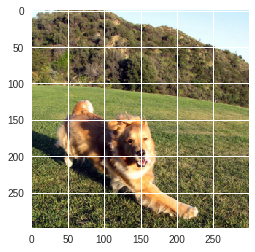

In [61]:
batch = next(iter(test_iter))

img = path_field.vocab.itos[batch.path[0].item()]

img = plt.imread('Flicker8k_Dataset/' + img)
img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)

**Задание** Напишите цикл генерации из модели:

In [66]:
def sample(probs, temp):
    probs = F.log_softmax(probs.squeeze(), dim=0)
    probs = (probs / temp).exp()
    probs /= probs.sum()
    probs = probs.cpu().numpy()

    return np.random.choice(np.arange(len(probs)), p=probs)


def generate(model, img, temp=0.6):
    model.eval()
    with torch.no_grad():        
        prev_token = train_iter.dataset.fields['target'].vocab.stoi['<s>']
        end_token = train_iter.dataset.fields['target'].vocab.stoi['</s>']
        
        hidden = None
        for _ in range(150):
            probs, hidden = model(img, LongTensor([[prev_token]]), hidden)
            prev_token = sample(probs, temp)
            
            if prev_token == end_token:
                return
            
            print(train_iter.dataset.fields['target'].vocab.itos[prev_token], end=' ')
                
generate(model, FloatTensor([img_vectors[11]]))

a skier in a ski suit is skiing alone with people in the background . 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


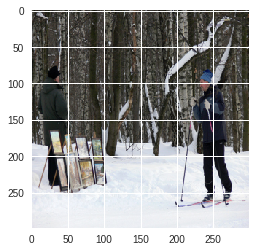

In [65]:
# Images and paths are 1-element shifted
img = path_field.vocab.itos[12]

img = plt.imread('Flicker8k_Dataset/' + img)
img = imresize(img, (299, 299)).astype('float32') / 255.
plt.imshow(img)

# Дополнительные материалы

## Статьи
Sequence to Sequence Learning with Neural Networks, Ilya Sutskever, et al, 2014 [[pdf]](https://arxiv.org/pdf/1409.3215.pdf)  
Show and Tell: A Neural Image Caption Generator, Oriol Vinyals et al, 2014 [[arxiv]](https://arxiv.org/abs/1411.4555)  
Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks, Samy Bengio, et al, 2015 [[arxiv]](https://arxiv.org/abs/1506.03099)  
Neural Machine Translation of Rare Words with Subword Units, Rico Sennrich, 2015 [[arxiv]](https://arxiv.org/abs/1508.07909)  
Massive Exploration of Neural Machine Translation Architectures, Denny Britz, et al, 2017 [[pdf]](https://arxiv.org/pdf/1703.03906.pdf)

## Блоги
Neural Machine Translation (seq2seq) Tutorial [tensorflow/nmt](https://github.com/tensorflow/nmt)  
[A Word of Caution on Scheduled Sampling for Training RNNs](https://www.inference.vc/scheduled-sampling-for-rnns-scoring-rule-interpretation/)

## Видео
cs224n, [Machine Translation, Seq2Seq and Attention](https://www.youtube.com/watch?v=IxQtK2SjWWM)

## Разное
[The Annotated Encoder Decoder](https://bastings.github.io/annotated_encoder_decoder/)  
[Seq2Seq-Vis: A Visual Debugging Tool for Sequence-to-Sequence Models](http://seq2seq-vis.io)

# Сдача

[Форма для сдачи](https://goo.gl/forms/28RaQihilt5NChaI2)  
[Feedback](https://goo.gl/forms/9aizSzOUrx7EvGlG3)